# Task 1: Anealing

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from keras.optimizers import Optimizer, SGD
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomNormal
from tqdm import tqdm_notebook as tqdm
import math
import collections
import random
from geopy.distance import geodesic
from keras.callbacks import TensorBoard
%matplotlib inline

Using TensorFlow backend.


In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5, random_state=2)

n_features = X.shape[1]
n_classes = Y.shape[1]

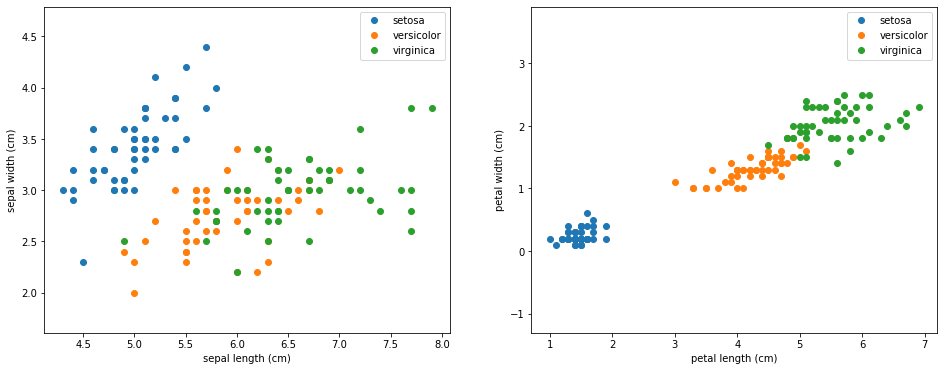

In [3]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

In [4]:
# Hyperparamaters
t = 5000
T_max = 30
T_min = 0.0005
a = 0.99
timestep = 10 # When to decrease temperature
sigma = 0.05

In [5]:
# Model Creation 
def create_model(input_dim, output_dim, nodes, n_layers=1, name="Iris_anealing_model", optimizer='adam'):
    model = Sequential(name=name)
    initializer = RandomNormal(0, sigma)
    for i in range(n_layers):
        model.add(Dense(nodes, input_dim=input_dim, kernel_initializer=initializer, activation='relu'))
    model.add(Dense(output_dim,  kernel_initializer=initializer, activation='softmax'))
    
    model.compile(loss='MSE', optimizer=optimizer, metrics=['accuracy'])
    return model

In [6]:
def p_star(cost_val, T):
    return np.exp(-cost_val/T)

In [7]:
# Custom training
def siman(model, t=t, T_max=T_max, T_min=T_min, a=a, sigma=sigma, timestep=timestep):
    # Make temporary model
    metric_history = collections.defaultdict(list)
    tmp_model = create_model(n_features, n_classes, 16)
    for t_step in tqdm(range(t)):
        for i, vals in enumerate(model.layers):
            new_vals = [np.random.normal(x, sigma) for x in vals.get_weights()]
            tmp_model.layers[i].set_weights(new_vals)

        # Anealing
        old_loss = model.evaluate(X_train, Y_train, verbose=0)[0]
        new_loss = tmp_model.evaluate(X_train, Y_train, verbose=0)[0]
        
        old_p = p_star(old_loss, T_max)
        new_p = p_star(new_loss, T_max)
        
        acc_ratio = new_p/old_p
        metric_history['p_star'].append(old_p)
        u = np.random.uniform(0, 1)

        # Acceptance
        if u <= acc_ratio:
            for i, vals in enumerate(tmp_model.layers):
                model.layers[i].set_weights(vals.get_weights())

        # Temperature reduction each timestep
        if t_step % timestep:
            T_max = T_max * a

        # Saving metrics for future visualization
        # Loss and accuracy
        loss, accuracy = model.evaluate(X_train, Y_train, verbose=0)
        val_loss, val_accuracy = model.evaluate(X_test, Y_test, verbose=0)
        
        metric_history['loss'].append(loss)
        metric_history['accuracy'].append(accuracy)
        metric_history['val_accuracy'].append(val_accuracy)
        metric_history['val_loss'].append(val_loss)
        
        if T_max <= T_min:
            return model, metric_history
    
    return model, metric_history

In [8]:
model_1 = create_model(n_features, n_classes, 16)
model_1.summary()

Model: "Iris_anealing_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Learn model 1
# The training will automatically end when T_max <= T_min
model_1, metric_history_1 = siman(model_1)

In [10]:
train_loss, train_acc = model_1.evaluate(X_train, Y_train) 
val_loss, val_acc = model_1.evaluate(X_test, Y_test)

75/75 [==============================] - ETA:  - 0s 66us/step


In [11]:
print(f"Training loss: {train_loss}\n"
      f"Training accuracy: {train_acc}\n"
      f"Validation loss: {val_loss}\n"
      f"Validation accuracy: {val_acc}\n")

Training loss: 0.05907023405035337
Training accuracy: 0.9200000166893005
Validation loss: 0.05160095114260912
Validation accuracy: 0.8933333158493042



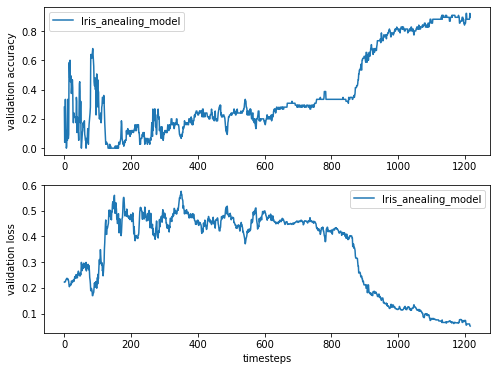

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

val_acc = metric_history_1['val_accuracy']
val_loss = metric_history_1['val_loss']
ax1.plot(val_acc, label=model_1.name)
ax2.plot(val_loss, label=model_1.name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('timesteps')
ax1.legend()
ax2.legend()
plt.show()

In [13]:
# Learning similar model model with Adam optimizer
model_2 = create_model(n_features, n_classes, 16)
model_2.summary()

Model: "Iris_anealing_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [14]:
# TensorBoard Callback
cb = TensorBoard()

history_callback = model_2.fit(X_train, Y_train,
                             batch_size=5,
                             epochs=50,
                             verbose=1,
                             validation_data=(X_test, Y_test),
                             callbacks=[cb])

Train on 75 samples, validate on 75 samples
Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.40 - ETA: 0s - loss: 0.2221 - accuracy: 0.40 - 0s 3ms/step - loss: 0.2210 - accuracy: 0.4933 - val_loss: 0.2191 - val_accuracy: 0.6933
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.60 - 0s 678us/step - loss: 0.2178 - accuracy: 0.6400 - val_loss: 0.2154 - val_accuracy: 0.6933
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.80 - 0s 652us/step - loss: 0.2135 - accuracy: 0.6400 - val_loss: 0.2096 - val_accuracy: 0.6933
Epoch 4/50
75/75 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.40 - 0s 652us/step - loss: 0.2066 - accuracy: 0.6533 - val_loss: 0.2011 - val_accuracy: 0.6933
Epoch 5/50
75/75 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 1.00 - 0s 678us/step - loss: 0.1973 - accuracy: 0.6400 - val_loss: 0.1892 - val_accuracy: 0.6

Epoch 45/50
75/75 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 1.00 - 0s 692us/step - loss: 0.0463 - accuracy: 0.9333 - val_loss: 0.0446 - val_accuracy: 0.9333
Epoch 46/50
75/75 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 1.00 - 0s 691us/step - loss: 0.0450 - accuracy: 0.9467 - val_loss: 0.0441 - val_accuracy: 0.9333
Epoch 47/50
75/75 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 1.00 - 0s 652us/step - loss: 0.0439 - accuracy: 0.9467 - val_loss: 0.0431 - val_accuracy: 0.9333
Epoch 48/50
75/75 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 1.00 - 0s 652us/step - loss: 0.0430 - accuracy: 0.9467 - val_loss: 0.0427 - val_accuracy: 0.9333
Epoch 49/50
75/75 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.80 - 0s 652us/step - loss: 0.0417 - accuracy: 0.9467 - val_loss: 0.0413 - val_accuracy: 0.9333
Epoch 50/50
75/75 [==============================] - ETA: 0s - loss: 0.1113

In [15]:
train_loss, train_acc = model_2.evaluate(X_train, Y_train) 
val_loss, val_acc = model_2.evaluate(X_test, Y_test)

75/75 [==============================] - ETA:  - 0s 66us/step


In [16]:
print(f"Training loss: {train_loss}\n"
      f"Training accuracy: {train_acc}\n"
      f"Validation loss: {val_loss}\n"
      f"Validation accuracy: {val_acc}\n")

Training loss: 0.039763242850701014
Training accuracy: 0.9466666579246521
Validation loss: 0.04024777486920357
Validation accuracy: 0.9333333373069763



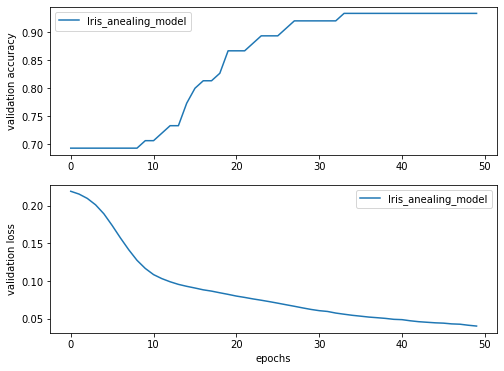

In [17]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

val_acc = history_callback.history['val_accuracy']
val_loss = history_callback.history['val_loss']
ax1.plot(val_acc, label=model_2.name)
ax2.plot(val_loss, label=model_2.name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

# Task 2: Combinatorial optimization

In [50]:
all_cities = pd.read_csv("tableconvert_2020-01-29_230320.csv")
all_cities

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,...,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
0,385200.0,Респ,Адыгея,NaN,NaN,г,Адыгейск,NaN,NaN,100000200000,...,4: город,0,79403000000,7.970300e+10,107,UTC3,44.878372,39.190172,Южный,12689
1,385000.0,Респ,Адыгея,NaN,NaN,г,Майкоп,NaN,NaN,100000100000,...,4: город,2,79401000000,7.970100e+10,105,UTC4,44.609827,40.100653,Южный,144055
2,649000.0,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,NaN,NaN,400000100000,...,4: город,2,84401000000,8.470100e+07,400,UTC9,51.958268,85.960296,Сибирский,62861
3,658125.0,край,Алтайский,NaN,NaN,г,Алейск,NaN,NaN,2200000200000,...,4: город,0,1403000000,1.703000e+06,2201,UTC10,52.492091,82.779415,Сибирский,28528
4,656000.0,край,Алтайский,NaN,NaN,г,Барнаул,NaN,NaN,2200000100000,...,4: город,2,1401000000,1.701000e+06,2200,UTC11,53.348115,83.779836,Сибирский,635585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,152150.0,обл,Ярославская,р-н,Ростовский,г,Ростов,NaN,NaN,7601400100000,...,4: город,1,78410000000,7.863710e+10,7609,UTC1110,57.205018,39.437836,Центральный,31791
1107,152900.0,обл,Ярославская,р-н,Рыбинский,г,Рыбинск,NaN,NaN,7601500100000,...,4: город,1,78415000000,7.871500e+10,7610,UTC1111,58.048380,38.858338,Центральный,200771
1108,152300.0,обл,Ярославская,р-н,Тутаевский,г,Тутаев,NaN,NaN,7601600100000,...,4: город,1,78417000000,7.864310e+10,7611,UTC1112,57.867424,39.536823,Центральный,41001
1109,152610.0,обл,Ярославская,р-н,Угличский,г,Углич,NaN,NaN,7601700100000,...,4: город,1,78420000000,7.864610e+07,7612,UTC1113,57.522387,38.301979,Центральный,34505


In [51]:
all_cities['Население']

0        12689
1       144055
2        62861
3        28528
4       635585
         ...  
1106     31791
1107    200771
1108     41001
1109     34505
1110    591486
Name: Население, Length: 1111, dtype: int64

In [52]:
all_cities = all_cities.astype({'Население': 'int32'})
all_cities.dtypes

Индекс                               float64
Тип региона                           object
Регион                                object
Тип района                            object
Район                                 object
Тип города                            object
Город                                 object
Тип н/п                               object
Н/п                                   object
Код КЛАДР                              int64
Код ФИАС                              object
Уровень по ФИАС                       object
Признак центра района или региона      int64
Код ОКАТО                              int64
Код ОКТМО                            float64
Код ИФНС                               int64
Часовой пояс                          object
Широта                               float64
Долгота                              float64
Федеральный округ                     object
Население                              int32
dtype: object

In [53]:
top_cities = all_cities.nlargest(30, "Население")
top_cities

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,...,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
506,101000.0,г,Москва,NaN,NaN,NaN,Москва,NaN,NaN,7700000000000,...,1: регион,0,45000000000,NaN,7700,UTC509,55.753879,37.620373,Центральный,11514330
782,190000.0,г,Санкт-Петербург,NaN,NaN,NaN,Санкт-Петербург,NaN,NaN,7800000000000,...,1: регион,0,40000000000,NaN,7800,UTC785,59.939125,30.315822,Северо-Западный,4848742
643,630000.0,обл,Новосибирская,NaN,NaN,г,Новосибирск,NaN,NaN,5400000100000,...,4: город,2,50401000000,5.070100e+10,5400,UTC650,55.028102,82.921057,Сибирский,1498921
828,620000.0,обл,Свердловская,NaN,NaN,г,Екатеринбург,NaN,NaN,6600000100000,...,4: город,2,65401000000,6.570100e+07,6600,UTC833,56.838633,60.605489,Уральский,1377738
615,603000.0,обл,Нижегородская,NaN,NaN,г,Нижний Новгород,NaN,NaN,5200000100000,...,4: город,2,22401000000,2.270100e+07,5200,UTC618,56.324209,44.005395,Приволжский,1250615
923,420000.0,Респ,Татарстан,NaN,NaN,г,Казань,NaN,NaN,1600000100000,...,4: город,2,92401000000,9.270100e+07,1600,UTC927,55.794388,49.111531,Приволжский,1216965
778,443000.0,обл,Самарская,NaN,NaN,г,Самара,NaN,NaN,6300000100000,...,4: город,2,36401000000,3.670100e+07,6300,UTC782,53.195166,50.106769,Приволжский,1164900
652,644000.0,обл,Омская,NaN,NaN,г,Омск,NaN,NaN,5500000100000,...,4: город,2,52401000000,5.270100e+10,5500,UTC658,54.984814,73.367464,Сибирский,1154000
1059,454000.0,обл,Челябинская,NaN,NaN,г,Челябинск,NaN,NaN,7400000100000,...,4: город,2,75401000000,7.570100e+10,7400,UTC1065,55.160366,61.400786,Уральский,1130273
753,344000.0,обл,Ростовская,NaN,NaN,г,Ростов-на-Дону,NaN,NaN,6100000100000,...,4: город,2,60401000000,6.070100e+10,6100,UTC756,47.222436,39.718787,Южный,1091544


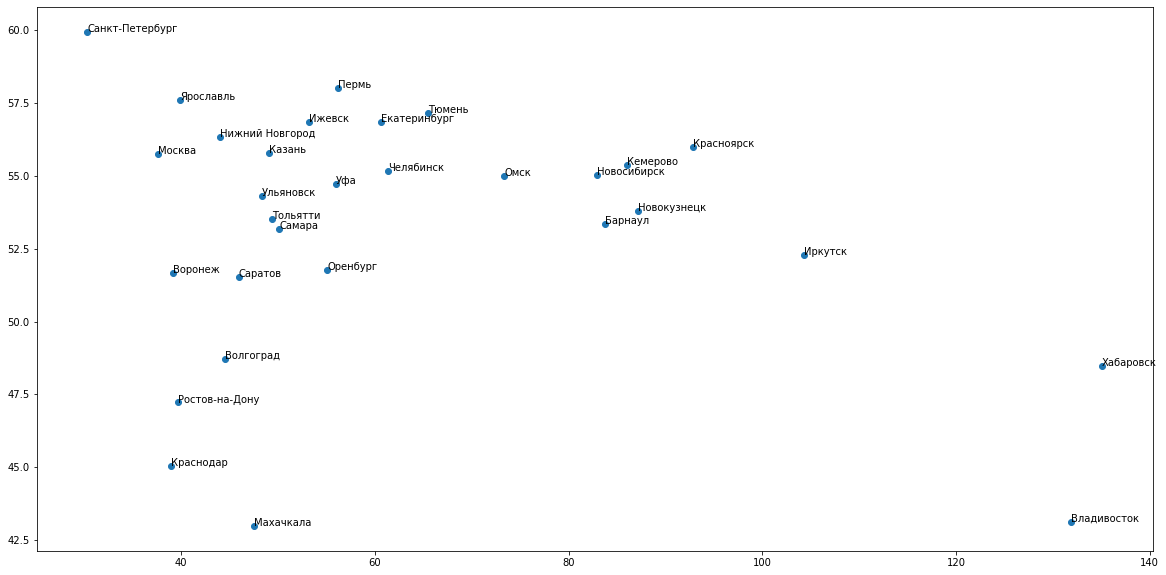

In [54]:
# Drawing cities on geographical position
fig, ax = plt.subplots(figsize=(20, 10))

plt.scatter(top_cities['Долгота'], top_cities['Широта'],)

for _, v in top_cities.iterrows():
    ax.annotate(v['Город'], (v['Долгота'], v['Широта']))


In [55]:
def reverse_path(seq):
    n = len(seq)
    i = random.randint(0, n-1)
    j = random.randint(0, n-1)
    new_seq = seq.copy()
    
    new_seq[i], new_seq[j] = new_seq[j], new_seq[i]
        
    return new_seq

def calc_energy(path, cities):
    
    cities_coord = top_cities.iloc[path][['Долгота', 'Широта']]
    score = 0
    
    for i in range(len(cities) - 1):
        city1 = (cities_coord['Широта'].iloc[i], cities_coord['Долгота'].iloc[i])
        city2 = (cities_coord['Широта'].iloc[i+1], cities_coord['Долгота'].iloc[i+1])
        
        score += geodesic(city1, city2).km
    city1 = (cities_coord['Широта'].iloc[0], cities_coord['Долгота'].iloc[0])
    city2 = (cities_coord['Широта'].iloc[-1], cities_coord['Долгота'].iloc[-1])
        
    score += geodesic(city1, city2).km
    return score

In [64]:
def SimulatedAnealingPath(cities, T_init=50000, T_end=0.001, timestep=3, t=t, a=a):
    n_cities = len(cities)
    metric_history = collections.defaultdict(list)
    
    # Initial random path
    curr_path = np.random.permutation(n_cities)
    curr_energy = calc_energy(curr_path, cities)
    
    best_energy = curr_energy
    best_path = curr_path
    
    for i in tqdm(range(t)):
        
        # Get random path
        new_path = reverse_path(curr_path)
        new_energy = calc_energy(new_path, cities)
        
        
        if new_energy < curr_energy:
            curr_energy = new_energy
            curr_path = new_path
            
            if curr_energy < best_energy:
                best_path = curr_path
                best_energy = curr_energy
        else:
            # Calcuale acceptance ratio
            if not p_star(curr_energy, T_init):
                return best_path, best_energy, metric_history 
            
            acc_ratio = p_star(new_energy, T_init)/p_star(curr_energy, T_init)
        
            u = np.random.uniform(0, 1)
            
            if u <= acc_ratio:
                curr_energy = new_energy
                curr_path = new_path
                
                if curr_energy < best_energy:
                    best_path = curr_path
                    best_energy = curr_energy
                    
        
        metric_history['best_energy'].append(best_energy)
        
        # Temperature reduction each timestep
        if i % timestep:
            T_init = T_init * a
        
        if T_init <= T_end:
            return best_path, best_energy, metric_history
            
    return best_path, best_energy, metric_history

In [68]:
best_path, best_energy, metric_history = SimulatedAnealingPath(top_cities, t=20000, a=0.999)

In [69]:
print(f"Best length: {best_energy} km")

Best length: 20846.14176869681 km


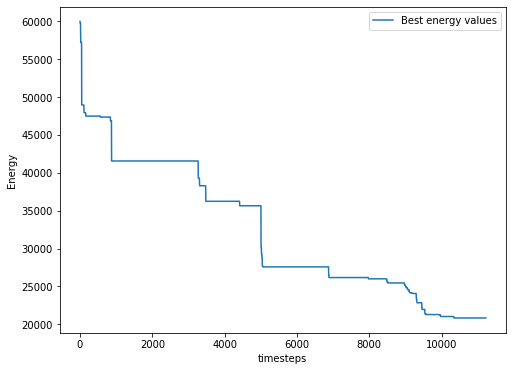

In [70]:
fig, ax1 = plt.subplots(figsize=(8, 6))

energy = metric_history['best_energy']
ax1.plot(energy, label="Best energy values")
    
ax1.set_ylabel('Energy')
ax1.set_xlabel('timesteps')
ax1.legend()
plt.show()

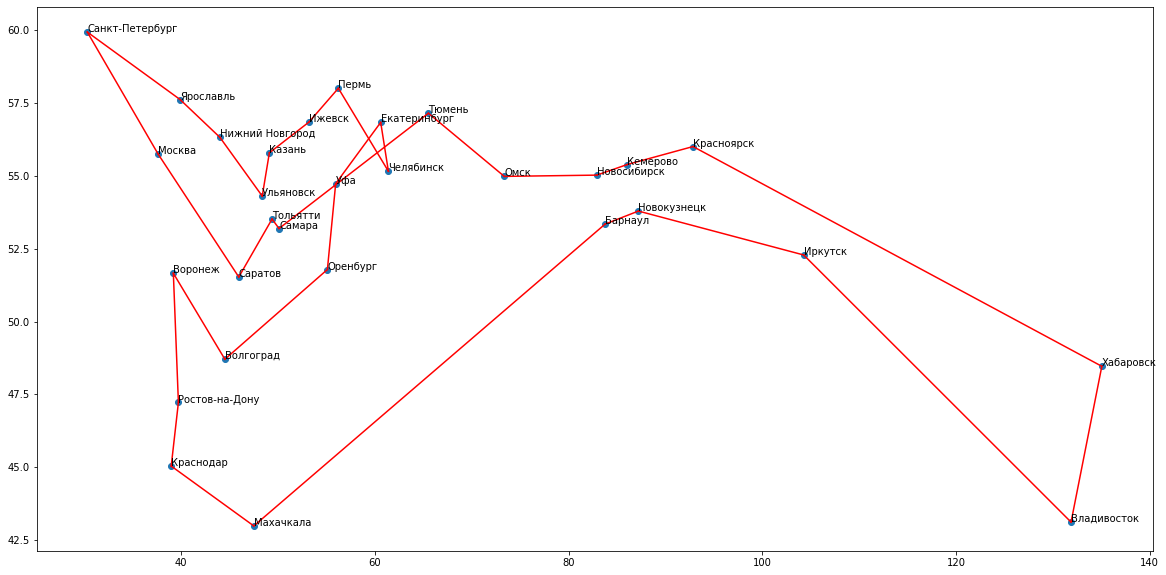

In [71]:
# Drawing cities on geographical position
fig, ax = plt.subplots(figsize=(20, 10))

cities_coord = top_cities.iloc[best_path][['Долгота', 'Широта', 'Город']]

plt.scatter(cities_coord['Долгота'], cities_coord['Широта'],)

for _, v in cities_coord.iterrows():
    ax.annotate(v['Город'], (v['Долгота'], v['Широта']))

for i in range(len(cities_coord) - 1):
    ax.plot((cities_coord['Долгота'].iloc[i], cities_coord['Долгота'].iloc[i+1]), 
        (cities_coord['Широта'].iloc[i], cities_coord['Широта'].iloc[i+1]), color='r')
    

ax.plot((cities_coord['Долгота'].iloc[0], cities_coord['Долгота'].iloc[-1]), 
        (cities_coord['Широта'].iloc[0], cities_coord['Широта'].iloc[-1]), color='r')